c:\VS code\code\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:512: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
c:\VS code\code\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:512: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
c:\VS code\code\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:512: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
c:\VS code\code\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:512: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
c:\VS code\code\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:512: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from font(s) DejaVu Sans.
  super()._update_title_posi

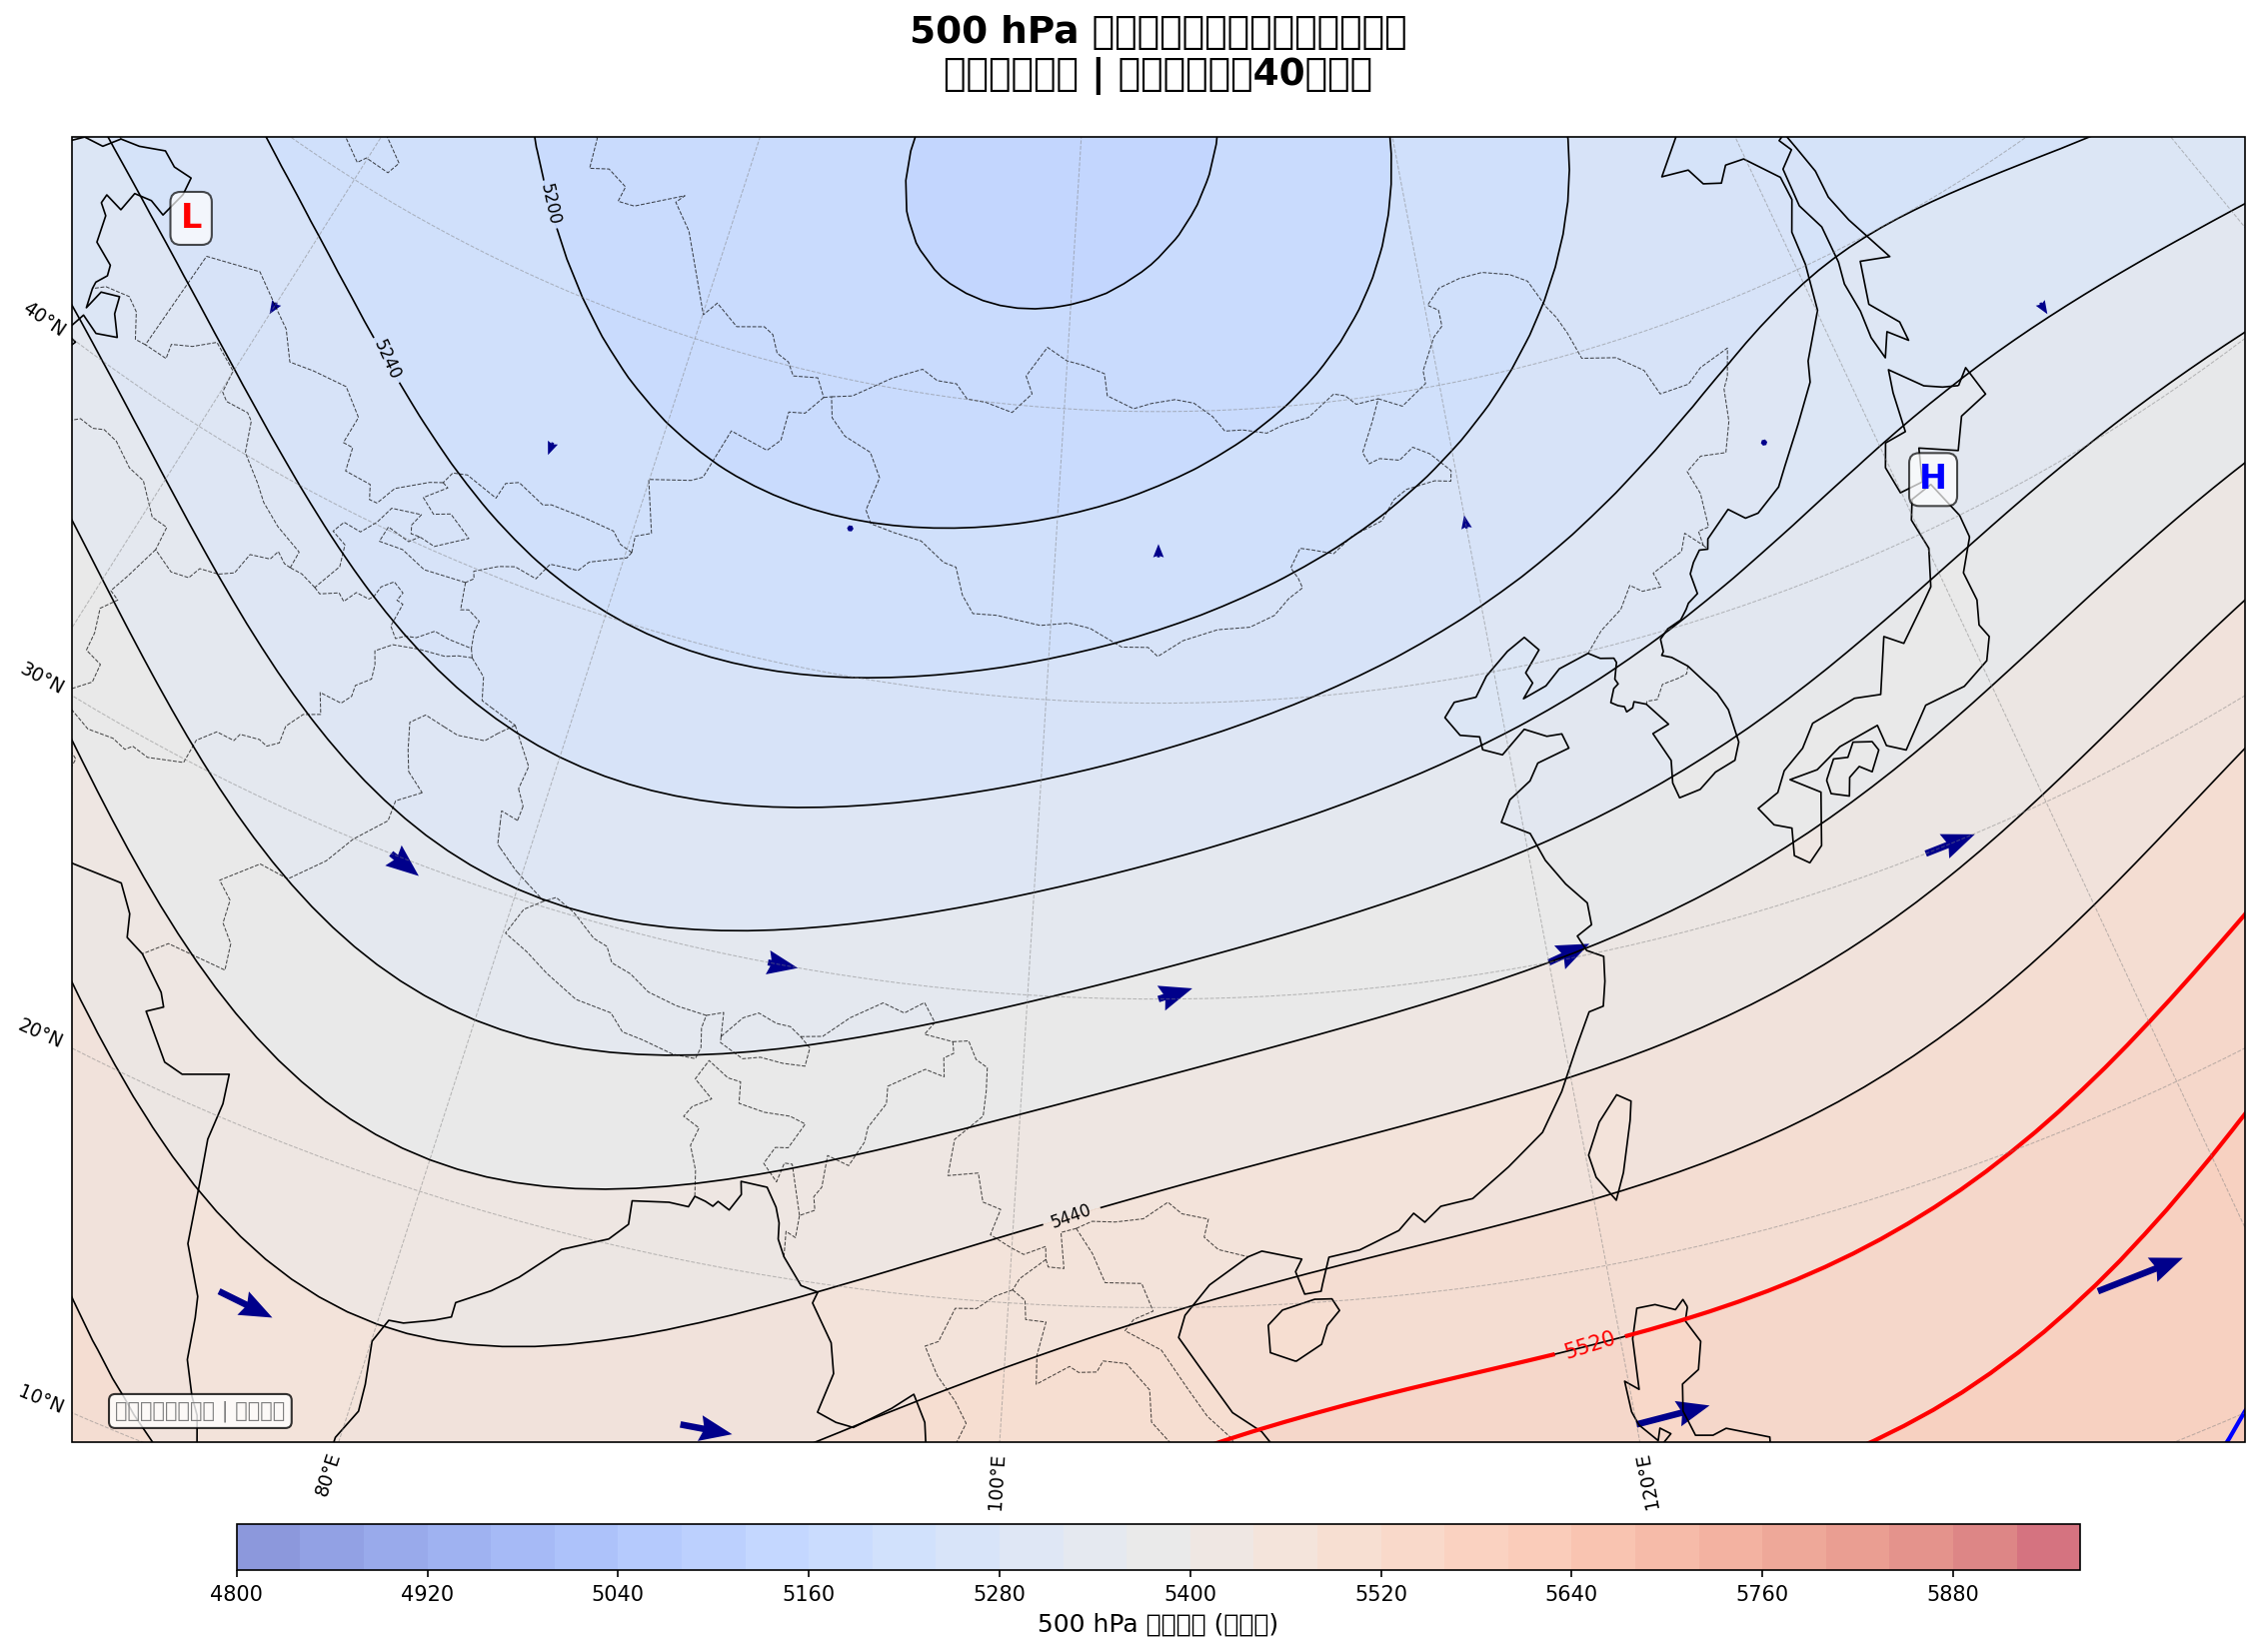

In [6]:
# -*- coding: utf-8 -*-
"""
气象局风格500hPa位势高度场 - 校赛优化版
"""
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# 1. 生成更真实的模拟数据（加入槽脊波动）
lon = np.linspace(-180, 180, 361)
lat = np.linspace(-90, 90, 181)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# 更真实的500hPa场：极地低、赤道高 + 西风带槽脊
hgt_500 = (
    5600  # 基准高度
    - 400 * np.sin(np.deg2rad(lat_grid) * 1.5) ** 2  # 赤道-极地梯度
    + 80 * np.sin(3 * np.deg2rad(lon_grid)) * np.cos(np.deg2rad(lat_grid))  # 3波槽脊
    - 40 * np.sin(6 * np.deg2rad(lon_grid)) * np.cos(np.deg2rad(lat_grid) * 2)  # 6波扰动
)

# 2. 创建地图 - 使用兰伯特投影（中纬度常用）
fig = plt.figure(figsize=(16, 12), dpi=150)  # 稍加大画布
proj = ccrs.LambertConformal(central_longitude=105, standard_parallels=(30, 60))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# 3. 设置中国及周边区域（气象局常用范围）
ax.set_extent([70, 140, 15, 55], crs=ccrs.PlateCarree())

# 4. 添加地理特征
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.7)
ax.add_feature(cfeature.OCEAN, facecolor='#e6f3ff', alpha=0.3)
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', alpha=0.2)

# 5. 【优化点1】绘制等高线填色图 - 更直观显示高低
# 使用 coolwarm 色带，蓝色低值，红色高值
contourf = ax.contourf(lon_grid, lat_grid, hgt_500, 
                       levels=np.arange(4800, 6000, 40), 
                       cmap='coolwarm', alpha=0.6,  # 半透明，不盖住地图
                       transform=ccrs.PlateCarree())

# 6. 绘制等高线
levels = np.arange(4800, 6000, 40)  # 每40位势米一条
cs = ax.contour(lon_grid, lat_grid, hgt_500, levels=levels,
                colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

# 7. 标注关键等高线（用红色加粗）
key_levels = [5520, 5560, 5600, 5640, 5680, 5760, 5840]
cs_key = ax.contour(lon_grid, lat_grid, hgt_500, levels=key_levels,
                    colors=['red', 'red', 'blue', 'blue', 'red', 'red', 'red'],
                    linewidths=[2, 2, 2, 2, 2, 2, 3],  # 5840加粗
                    transform=ccrs.PlateCarree())

# 8. 添加等高线数值标注
ax.clabel(cs, inline=True, fontsize=8, fmt='%d')
ax.clabel(cs_key, inline=True, fontsize=10, fmt='%d', colors=['red', 'red', 'blue', 'blue', 'red', 'red', 'red'])

# 9. 添加网格（经纬度线）
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                  alpha=0.5, linestyle='--', x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

# 10. 添加风场模拟
u_wind = 20 * np.cos(2 * np.deg2rad(lat_grid)) * (1 + 0.3 * np.sin(3 * np.deg2rad(lon_grid)))
v_wind = 5 * np.sin(4 * np.deg2rad(lon_grid)) * np.sin(np.deg2rad(lat_grid))
skip = 15
wind_quiver = ax.quiver(lon_grid[::skip, ::skip], lat_grid[::skip, ::skip],
          u_wind[::skip, ::skip], v_wind[::skip, ::skip],
          transform=ccrs.PlateCarree(), color='darkblue', scale=500,
          width=0.003, headwidth=4, headlength=5)

# 11. 【优化点2】为风矢量添加图例
qk = ax.quiverkey(wind_quiver, 0.92, 0.03, 10, r'$10\ m/s$', 
                  labelpos='E', coordinates='figure', fontproperties={'size': 10})

# 12. 【优化点3】调整标题和系统标识位置，并添加署名
ax.set_title('500 hPa 位势高度场与风场（模拟数据）\n单位：位势米 | 等值线间隔：40位势米', 
             fontsize=18, fontweight='bold', pad=25, loc='center')

# 将高低压标识移到更合适的位置
ax.text(0.05, 0.95, 'L', transform=ax.transAxes, fontsize=16,
        fontweight='bold', color='red', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
ax.text(0.85, 0.75, 'H', transform=ax.transAxes, fontsize=16,
        fontweight='bold', color='blue', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

# 在左下角添加项目署名
ax.text(0.02, 0.02, '气象数据分析系统 | 校赛作品', transform=ax.transAxes,
        fontsize=10, style='italic', color='gray',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# 13. 添加色标 (colorbar)，解释填色含义
cbar = plt.colorbar(contourf, ax=ax, orientation='horizontal', 
                    pad=0.05, shrink=0.8, aspect=40)
cbar.set_label('500 hPa 位势高度 (位势米)', fontsize=12)

plt.tight_layout()
plt.savefig('500hPa_气象局风格_校赛版.png', dpi=300, bbox_inches='tight')
plt.show()
# 14. 添加关键系统标注（带说明框，更清晰）
# 低压中心标注 - 用带解释的文本框
low_text = ax.text(0.05, 0.95, 'L (低压中心)', transform=ax.transAxes, 
                   fontsize=13, fontweight='bold', color='red', 
                   va='top', ha='left',
                   bbox=dict(boxstyle="round,pad=0.4", facecolor='white', 
                             edgecolor='red', alpha=0.8))
# 高压中心标注
high_text = ax.text(0.85, 0.75, 'H (高压中心)', transform=ax.transAxes, 
                    fontsize=13, fontweight='bold', color='blue',
                    va='top', ha='left',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', 
                              edgecolor='blue', alpha=0.8))

# （可选）在角落添加简易图例，强化记忆
legend_elements = [Patch(facecolor='red', edgecolor='red', alpha=0.7, label='低压 (L): 阴雨大风'),
                   Patch(facecolor='blue', edgecolor='blue', alpha=0.7, label='高压 (H): 晴朗稳定')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9, 
          title='天气系统标识', title_fontsize=10, framealpha=0.9)